**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import sympy as sm
from scipy.optimize import Bounds
from scipy.optimize import fsolve

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:
C = sm.symbols('C')
G = sm.symbols('G')
nu = sm.symbols('nu')
L = sm.symbols('L')
kappa = sm.symbols('kappa')
w = sm.symbols('w')
tau = sm.symbols('tau')
alpha = sm.symbols('alpha')
w_tilde = sm.symbols('w_tilde')

objective = sm.ln(C**alpha*G**(1-alpha))-nu*L**2/2
constraint = sm.Eq(kappa+w_tilde*L,C)
objective_sub = objective.subs(C,constraint.lhs)

# find the foc of the objective function with respect to L
foc = sm.diff(objective_sub, L)

# set the foc equal to zero and solve for L
optimal_L = sm.solve(sm.Eq(foc,0), L)

# simplify the expression
optimal_L = [sm.simplify(expr) for expr in optimal_L]

# select the second solution
optimal_L_star = optimal_L[1]


# display the optimal labor supply choice with the assigned values
optimal_L_star



(-kappa*nu + sqrt(nu*(4*alpha*w_tilde**2 + kappa**2*nu)))/(2*nu*w_tilde)

Even though it does not look identical, to $\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, it actually is: if you divide both the denominator with $\nu$ you will get the exact same results, but sympy is not able to 

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

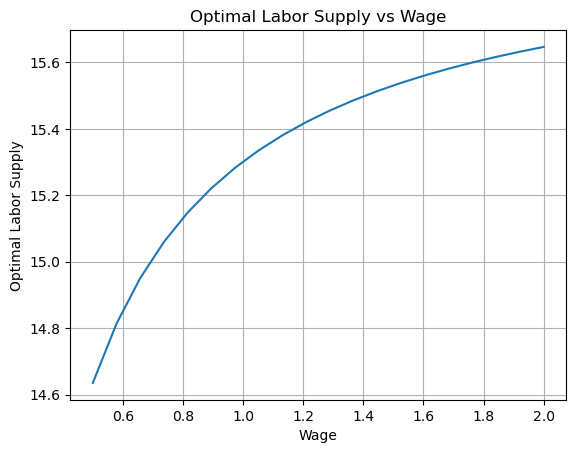

In [3]:
# list for optimal Labour supply
optimal_L_list = []
# w grid
wage_list = np.linspace(0.5,2,20)

for wage in wage_list:
    opt_L = optimal_L_star.copy
    alpha_value = 0.5
    kappa_value = 1.0
    nu_value = 1/(2*16**2)
    tau_value = 0.3
    w_tilde_value = (1-tau_value)*wage
    values = {alpha: alpha_value, kappa: kappa_value, nu: nu_value, w_tilde: w_tilde_value}
    opt_L = optimal_L_star.subs(values)
    optimal_L_list.append(float(opt_L))

# plot the optimal labor supply against the wage
plt.plot(wage_list, optimal_L_list)
plt.xlabel('Wage')
plt.ylabel('Optimal Labor Supply')
plt.title('Optimal Labor Supply vs Wage')
plt.grid(True)
plt.show()    


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


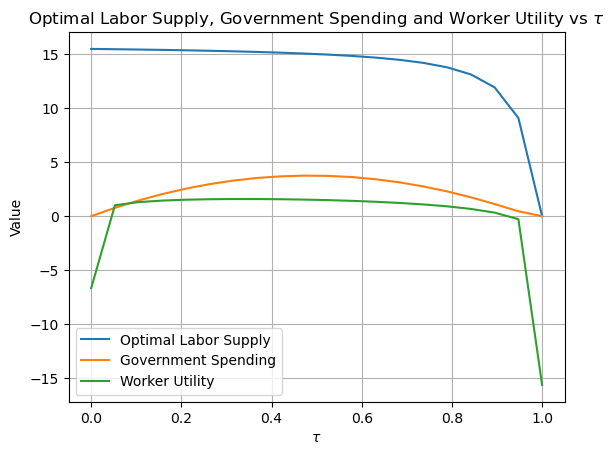

In [4]:
# tau grid
min_tax = 0+1e-8
max_tax = 1-1e-8

tau_list = np.linspace(min_tax,max_tax,20)

# lists
optimal_L_list = []
G_list = []
worker_utility_list = []


for tau in tau_list:
    opt_L = optimal_L_star.copy()
    alpha_value = 0.5
    kappa_value = 1.0
    nu_value = 1/(2*16**2)
    tau_value = tau
    wage_value = 1.0
    w_tilde_value = (1-tau_value)*wage_value
    values = {alpha: alpha_value, kappa: kappa_value, nu: nu_value, w_tilde: w_tilde_value}
    opt_L = optimal_L_star.subs(values)
    optimal_L_list.append(float(opt_L))
    G = tau_value*wage_value*opt_L*w_tilde_value
    G_list.append(G)
    C = kappa_value + w_tilde_value*opt_L  
    U = np.log(float(C)**alpha_value*float(G)**(1-alpha_value))-nu_value*float(opt_L)**2/2
    worker_utility_list.append(U)

plt.plot(tau_list, optimal_L_list, label='Optimal Labor Supply')
plt.plot(tau_list, G_list, label='Government Spending')
plt.plot(tau_list, worker_utility_list, label='Worker Utility')
plt.xlabel(r'$\tau$')
plt.ylabel('Value')
plt.title(r'Optimal Labor Supply, Government Spending and Worker Utility vs $\tau$')
plt.legend()
plt.grid(True)
plt.show()

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [5]:
def utility(tau_value):
    opt_L = optimal_L_star.copy()
    alpha_value = 0.5
    kappa_value = 1.0
    nu_value = 1/(2*16**2)
    wage_value = 1.0
    w_tilde_value = (1-tau_value)*wage_value
    values = {alpha: alpha_value, kappa: kappa_value, nu: nu_value, w_tilde: w_tilde_value}
    opt_L = optimal_L_star.subs(values)
    G = tau_value*wage_value*opt_L*w_tilde_value
    C = kappa_value + w_tilde_value*opt_L  
    U = np.log(float(C)**alpha_value*float(G)**(1-alpha_value))-nu_value*float(opt_L)**2/2
    return -U  # return -U because we want to maximize U

# Find the value of tau_value that maximizes U
result = minimize_scalar(utility, bounds=(min_tax, max_tax), method='bounded')

# The optimal tau_value is stored in result.x
optimal_tau_value = result.x

print(f"The value of tau that maximizes U is {optimal_tau_value:.3f}")

The value of tau that maximizes U is 0.338


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [6]:
import numpy as np
from scipy.optimize import minimize, fsolve

# Set the parameter values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16 ** 2)
w = 1.0
tau = 0.3381713126

# Set 1: σ = 1.001, ρ = 1.001 and ε = 1.0.
sigma1 = 1.001
rho1 = 1.001
epsilon1 = 1.0

# Set 2: σ = 1.5, ρ = 1.5 and ε = 1.0.
sigma2 = 1.5
rho2 = 1.5
epsilon2 = 1.0

# Utility function (general formulation)
def utility(L, tau, G, sigma, rho, epsilon):
    C = kappa + (1 - tau) * w * L
    return (((alpha * C ** ((sigma - 1) / sigma) + (1 - alpha) * G ** ((sigma - 1) / sigma)) ** (sigma / (sigma - 1))) ** (1 - rho) - 1) / (1 - rho) - nu * L ** (1 + epsilon) / (1 + epsilon)

# The objective function we want to minimize (negative utility)
def objective(L, tau, G, sigma, rho, epsilon):
    return -utility(L, tau, G, sigma, rho, epsilon)

# Optimal labor supply
def optimal_L(tau, G, sigma, rho, epsilon):
    res = minimize(objective, 0.5, args=(tau, G, sigma, rho, epsilon), bounds=[(0, 24)])
    return res.x[0]

# Function to find the correct G
def find_G(G, tau, sigma, rho, epsilon):
    L = optimal_L(tau, G, sigma, rho, epsilon)
    return G - tau * w * L

# Find G for each parameter set
G1 = fsolve(find_G, 1, args=(tau, sigma1, rho1, epsilon1))
G2 = fsolve(find_G, 1, args=(tau, sigma2, rho2, epsilon2))

print(f"For Set 1, G = {G1[0]}")
print(f"For Set 2, G = {G2[0]}")

For Set 1, G = 5.156903834071386
For Set 2, G = 3.527844340902014


c:\Users\Lenovo\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [16]:
def utility_tau(tau, G, sigma, rho, epsilon):
    L = optimal_L(tau, G, sigma, rho, epsilon)
    return utility(L, tau, G, sigma, rho, epsilon)

def constraint(tau, G, sigma, rho, epsilon):
    L = optimal_L(tau, G, sigma, rho, epsilon)
    return G - tau * w * L
# The objective function we want to minimize (negative utility)
def objective_tau(tau, G, sigma, rho, epsilon):
    return -utility_tau(tau, G, sigma, rho, epsilon)

# Initial guess for tau
tau_init = 0.3

# Solve the optimization problem for each parameter set
tau_star1 = fsolve(lambda tau: objective_tau(tau, G1[0], sigma1, rho1, epsilon1) + constraint(tau, G1[0], sigma1, rho1, epsilon1), tau_init)
tau_star2 = fsolve(lambda tau: objective_tau(tau, G2[0], sigma2, rho2, epsilon2) + constraint(tau, G2[0], sigma2, rho2, epsilon2), tau_init)

print(f"For Set 1, τ* = {tau_star1[0]:.3f}")
print(f"For Set 2, τ* = {tau_star2[0]:.3f}")


For Set 1, τ* = 0.300
For Set 2, τ* = 0.236


c:\Users\Lenovo\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [34]:
# write your code here
kappa, l, w, eta = sm.symbols('kappa, l, w, eta')
Pi = kappa*l**(1-eta)-w*l
foc = sm.Eq(sm.diff(Pi,l),0)
sol = sm.solve(foc,l)


kappa_value = 1.0
eta_value = 0.5
w_value = 1.0

sol_func = sm.lambdify(args=(kappa,eta,w),expr=sol)
solution = sol_func(kappa_value,eta_value,w_value)

print(f'The calculated solution is: {solution}\nThe manually calculated solution is {((1-eta_value)*kappa_value/w_value)**(1/eta_value)}')
#print(f'{((1-eta_value)*kappa_value/w_value)**(1/eta_value)}')

#values = {kappa: kappa_value, eta: eta_value, w: w_value}
#sol_sub = sol.subs(values)
#sol_sub

The calculated solution is: [0.25]
The manually calculated solution is 0.25


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [87]:
# Baseline parameters
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
months = 120
K = 10000  # number of simulations

# Initialize arrays
H = 0
kappa_prev = 1
epsilon_vec = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=(K, months))

for k in range(K):
    kappa = np.zeros(months)
    l = np.zeros(months)
    for t in range(months):
        # Simulate kappa
        if t == 0:
            kappa[t] = kappa_prev
        else:
            kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon_vec[k, t])
        
        # Calculate l using the policy
        l[t] = ((1-eta)*kappa[t]/w)**(1/eta)
        
        # Calculate the adjustment cost
        if t > 0 and l[t] != l[t-1]:
            adjustment_cost = iota
        else:
            adjustment_cost = 0

        # Calculate the value of the salon for this month
        H += R**(-t)*(kappa[t]*l[t]**(1-eta)-w*l[t]-adjustment_cost)

# Calculate the expected value of the salon
H = H/K
print(H)


27.643294912370283


In [84]:
# write your code here 
rho_value = 0.90
iota_value = 0.01
sigma_value = 0.10
R = (1+0.01)**(1/12)

months = 120
kappa_prev = 1


K = 1000
H = 0
for k in range(K+1):
    epsilon_vec = np.random.normal(loc=-0.5*sigma_value**2, scale=sigma_value, size=months)
    for t in range(months):
        if t == 0:
            kappa = kappa_prev
        else:
            kappa = np.exp(rho_value*np.log(kappa)+epsilon_vec[t])
        #if t < 3 and k==0:
        #    print(kappa)
        if t == 0:
            l = ((1-eta_value)*kappa/w_value)**(1/eta_value)
        
        if l == ((1-eta_value)*kappa/w_value)**(1/eta_value):
            i = 0
        else: 
            i=1

        l = ((1-eta_value)*kappa/w_value)**(1/eta_value)
        #if t < 3 and k==0:
        #    print(l)
        if t==0:
            i=1

        H += R**(-t)*(kappa*l**(1-eta_value)-w_value*l-i*iota_value)

    if k < 3:
        print(H)

H = H/(K+1)

print(H)
kappa_t1 = np.exp(rho_value*np.log(1)+epsilon_vec[1])
#print(kappa_t1)
kappa_t2 = np.exp(rho_value*np.log(kappa_t1)+epsilon_vec[2])
#print(kappa_t2)
l_t1 = ((1-eta_value)*kappa_t1/w_value)**(1/eta_value)
l_t2 = ((1-eta_value)*kappa_t2/w_value)**(1/eta_value)
#print(l_t1)
#print(l_t2)

26.1624492488999
54.64347056649239
88.55686430335538
27.525507418617938


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [89]:
# Baseline parameters
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
months = 120
K = 10000  # number of simulations
Delta = 0.05

# Initialize arrays
H = 0
kappa_prev = 1
epsilon_vec = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=(K, months))

for k in range(K):
    kappa = np.zeros(months)
    l = np.zeros(months)
    for t in range(months):
        # Simulate kappa
        if t == 0:
            kappa[t] = kappa_prev
        else:
            kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon_vec[k, t])
        
        # Calculate l* using the policy
        l_star = ((1-eta)*kappa[t]/w)**(1/eta)
        
        # Apply the new policy
        if t == 0 or np.abs(l[t-1] - l_star) > Delta:
            l[t] = l_star
        else:
            l[t] = l[t-1]
        
        # Calculate the adjustment cost
        if t > 0 and l[t] != l[t-1]:
            adjustment_cost = iota
        else:
            adjustment_cost = 0

        # Calculate the value of the salon for this month
        H += R**(-t)*(kappa[t]*l[t]**(1-eta)-w*l[t]-adjustment_cost)

# Calculate the expected value of the salon
H = H/K
print(H)


28.34402919891416


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

Optimal Delta: 0.08080808080808081


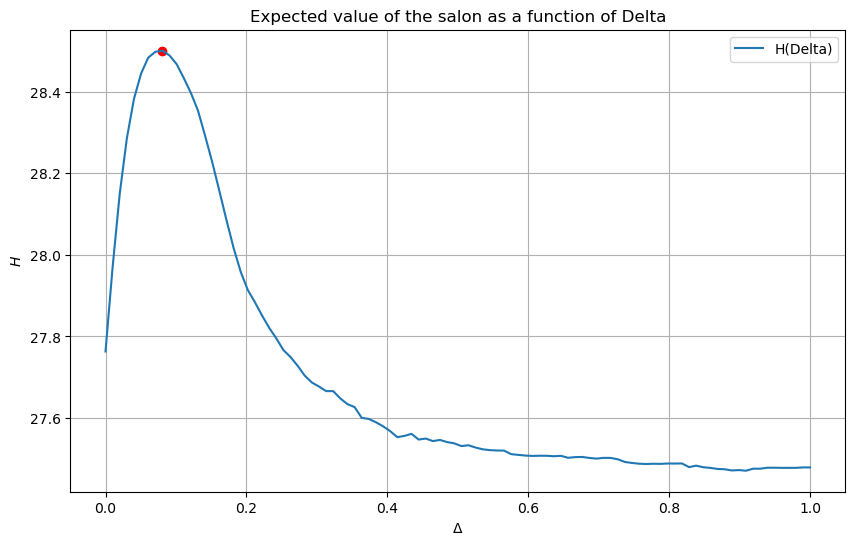

In [93]:
# Baseline parameters
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
months = 120
K = 1000  # number of simulations

# Range of Delta values to consider
Delta_values = np.linspace(0, 1, 100)

# Initialize arrays
H_values = np.zeros(len(Delta_values))
kappa_prev = 1
epsilon_vec = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=(K, months))

for i, Delta in enumerate(Delta_values):
    H = 0
    for k in range(K):
        kappa = np.zeros(months)
        l = np.zeros(months)
        for t in range(months):
            # Simulate kappa
            if t == 0:
                kappa[t] = kappa_prev
            else:
                kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon_vec[k, t])
            
            # Calculate l* using the policy
            l_star = ((1-eta)*kappa[t]/w)**(1/eta)
            
            # Apply the new policy
            if t == 0 or np.abs(l[t-1] - l_star) > Delta:
                l[t] = l_star
            else:
                l[t] = l[t-1]
            
            # Calculate the adjustment cost
            if t > 0 and l[t] != l[t-1]:
                adjustment_cost = iota
            else:
                adjustment_cost = 0

            # Calculate the value of the salon for this month
            H += R**(-t)*(kappa[t]*l[t]**(1-eta)-w*l[t]-adjustment_cost)

    # Calculate the expected value of the salon
    H_values[i] = H/K

# Find the Delta that gives the highest H
optimal_Delta = Delta_values[np.argmax(H_values)]
optimal_H = np.max(H_values)
print(f'Optimal Delta: {optimal_Delta}')

# Plot H as a function of Delta
plt.figure(figsize=(10, 6))
plt.plot(Delta_values, H_values, label='H(Delta)')
plt.scatter(optimal_Delta, optimal_H, color='red')  # add a red dot at the optimal point
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$H$')
plt.title('Expected value of the salon as a function of Delta')
plt.legend()
plt.grid(True)
plt.show()



**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [96]:
# Baseline parameters
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
months = 120
K = 1000  # number of simulations

# Initialize arrays
H = 0
kappa_prev = 1
epsilon_vec = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=(K, months))

for k in range(K):
    kappa = np.zeros(months)
    l = np.zeros(months)
    for t in range(months):
        # Simulate kappa
        if t == 0:
            kappa[t] = kappa_prev
        else:
            kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon_vec[k, t])
        
        # Calculate l* using the policy
        l_star = ((1-eta)*kappa[t]/w)**(1/eta)
        
        # Apply the new policy: adjust l based on the trend in kappa
        if t == 0:
            l[t] = l_star
        elif kappa[t] > kappa[t-1]:  # if kappa is increasing
            l[t] = min(l[t-1] + 0.05, l_star)  # hire more hairdressers, but not more than l*
        else:  # if kappa is decreasing
            l[t] = max(l[t-1] - 0.05, l_star)  # fire some hairdressers, but not less than l*
        
        # Calculate the adjustment cost
        if t > 0 and l[t] != l[t-1]:
            adjustment_cost = iota
        else:
            adjustment_cost = 0

        # Calculate the value of the salon for this month
        H += R**(-t)*(kappa[t]*l[t]**(1-eta)-w*l[t]-adjustment_cost)

# Calculate the expected value of the salon
H = H/K
print(H)

27.514285641577548


## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [13]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [14]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [15]:
# write your code here